In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c rossmann-store-sales

# Unzip the downloaded files
!unzip rossmann-store-sales.zip -d rossmann-store-sales

# List the files in the extracted directory
!ls rossmann-store-sales

  0% 0.00/6.99M [00:00<?, ?B/s]
100% 6.99M/6.99M [00:00<00:00, 1.04GB/s]
Archive:  rossmann-store-sales.zip
  inflating: rossmann-store-sales/sample_submission.csv  
  inflating: rossmann-store-sales/store.csv  
  inflating: rossmann-store-sales/test.csv  
  inflating: rossmann-store-sales/train.csv  
sample_submission.csv  store.csv  test.csv  train.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Statistical models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from prophet import Prophet

In [6]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
# Load data
train = pd.read_csv('/content/rossmann-store-sales/train.csv', parse_dates=["Date"], engine='python')
test = pd.read_csv('/content/rossmann-store-sales/test.csv', parse_dates=["Date"])
store = pd.read_csv('/content/rossmann-store-sales/store.csv')

In [8]:
# Merge with store information
train = pd.merge(train, store, on="Store", how="left")
test = pd.merge(test, store, on="Store", how="left")

## > Missing value handling

In [9]:
for df in [train, test]:
        # Competition features
        df["CompetitionDistance"] = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
        df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(df["CompetitionOpenSinceMonth"].mode()[0])
        df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(df["CompetitionOpenSinceYear"].mode()[0])

        # Promo2 features
        df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0)
        df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0)
        df["PromoInterval"] = df["PromoInterval"].fillna("None")

        # Create competition months since opening
        df['CompetitionMonthsOpen'] = np.maximum(0,
            12 * (df['Date'].dt.year - df['CompetitionOpenSinceYear']) +
            (df['Date'].dt.month - df['CompetitionOpenSinceMonth']))

        # Create Promo2 active indicator
        df['Promo2Active'] = 0
        for interval in df['PromoInterval'].unique():
            if interval != 'None' and pd.notna(interval):
                months = interval.split(',')
                # Add a check for valid month abbreviations before parsing
                valid_months = [month.strip() for month in months if len(month.strip()) == 3]
                if valid_months: # Only proceed if there are valid months
                    try:
                        month_nums = [datetime.strptime(month, '%b').month for month in valid_months]
                        mask = (df['PromoInterval'] == interval) & (df['Date'].dt.month.isin(month_nums))
                        df.loc[mask, 'Promo2Active'] = 1
                    except ValueError:
                         # Handle cases where even 3-letter codes might be invalid
                         print(f"Warning: Could not parse month interval: {interval}")

In [10]:
# Set date as index and sort
train.set_index("Date", inplace=True)
test.set_index("Date", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [11]:
# Filter out closed stores and zero sales for training
train_filtered = train[(train["Open"] == 1) & (train["Sales"] > 0)].copy()

In [13]:
train_data = train_filtered.copy()

## > Feature engineering

In [16]:
def create_time_features(df):
    """time-based feature engineering"""
    df = df.copy()

    # Basic time features
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['DayOfWeek'] = df.index.dayofweek
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Quarter'] = df.index.quarter

    # Cyclical features (important for seasonality)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

    # Additional time indicators
    df['IsMonthStart'] = df.index.is_month_start.astype(int)
    df['IsMonthEnd'] = df.index.is_month_end.astype(int)
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    return df

--------------
## 01. Data Analysis & EDA

In [14]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionMonthsOpen,Promo2Active
Date,,,,,,,,,,,,,,,,,,,
2013-01-01,353,2,3139,820,1,0,a,1,b,b,900.0,9.0,2013.0,1,14.0,2013.0,"Feb,May,Aug,Nov",0.0,0
2013-01-01,335,2,2401,482,1,0,a,1,b,a,90.0,9.0,2013.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0.0,1
2013-01-01,512,2,2646,625,1,0,a,1,b,b,590.0,9.0,2013.0,1,5.0,2013.0,"Mar,Jun,Sept,Dec",0.0,0
2013-01-01,494,2,3113,527,1,0,a,1,b,a,1260.0,6.0,2011.0,0,0.0,0.0,None,19.0,0
2013-01-01,530,2,2907,532,1,0,a,1,a,c,18160.0,9.0,2013.0,0,0.0,0.0,None,0.0,0


In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-01 to 2015-07-31
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Sales                      844338 non-null  int64  
 3   Customers                  844338 non-null  int64  
 4   Open                       844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   StoreType                  844338 non-null  object 
 9   Assortment                 844338 non-null  object 
 10  CompetitionDistance        844338 non-null  float64
 11  CompetitionOpenSinceMonth  844338 non-null  float64
 12  CompetitionOpenSinceYear   844338 non-null  float64
 13  Promo2       

In [19]:
print("=== DATASET OVERVIEW ===")
print(f"Training data shape: {train_data.shape}")
print(f"Date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Number of stores: {train_data['Store'].nunique()}")
print(f"Average daily sales: ${train_data['Sales'].mean():.2f}")

=== DATASET OVERVIEW ===
Training data shape: (844338, 19)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Number of stores: 1115
Average daily sales: $6955.96


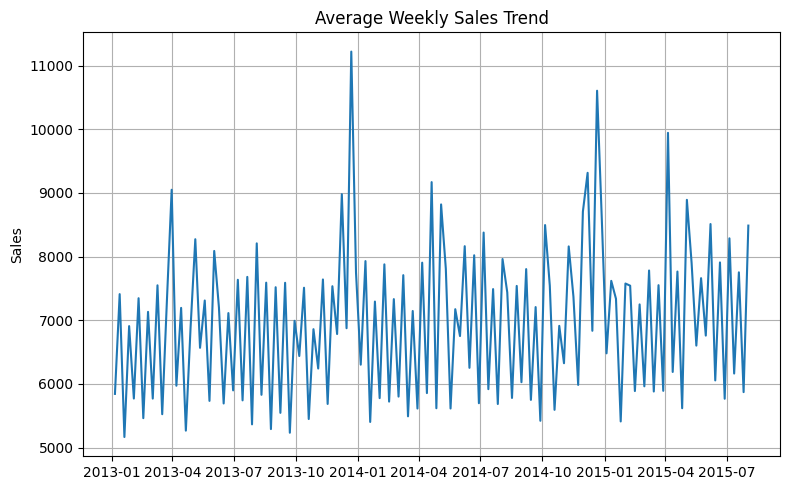

In [21]:
# 1. Sales trend over time
plt.figure(figsize=(8, 5))
weekly_sales = train_data.resample("W")["Sales"].mean()
plt.plot(weekly_sales)
plt.title("Average Weekly Sales Trend")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

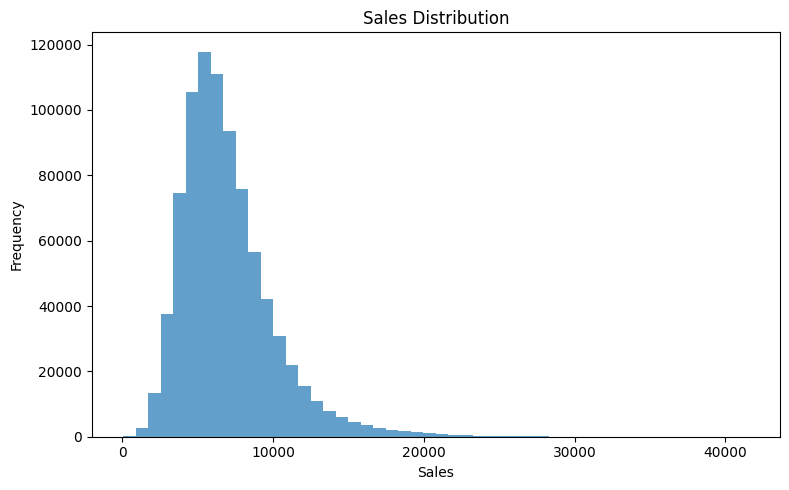

In [22]:
# 2. Sales distribution
plt.figure(figsize=(8, 5))
plt.hist(train_data['Sales'], bins=50, alpha=0.7)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

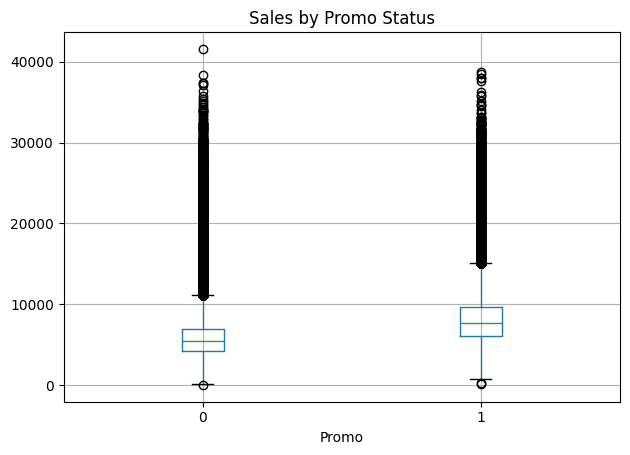

In [23]:
# 3. Promo impact
plt.figure(figsize=(8, 5))
train_data.boxplot(column='Sales', by='Promo')
plt.title("Sales by Promo Status")
plt.suptitle("")  # Removes automatic 'Boxplot grouped by' title
plt.tight_layout()
plt.show()

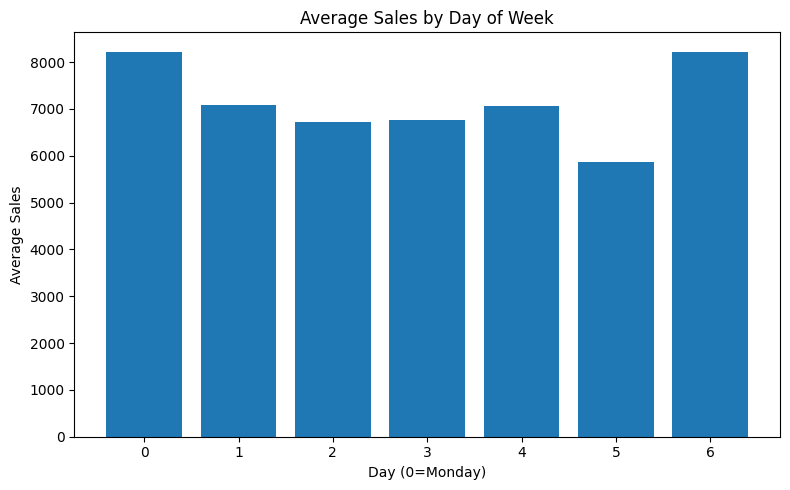

In [24]:
# 4. Day of week pattern
plt.figure(figsize=(8, 5))
dow_sales = train_data.groupby('DayOfWeek')['Sales'].mean()
plt.bar(range(7), dow_sales)
plt.title("Average Sales by Day of Week")
plt.xlabel("Day (0=Monday)")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

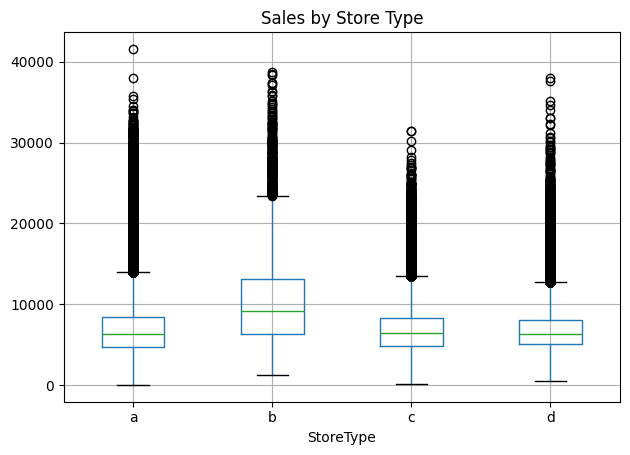

In [25]:
# 5. Store type comparison
plt.figure(figsize=(8, 5))
train_data.boxplot(column='Sales', by='StoreType')
plt.title("Sales by Store Type")
plt.suptitle("")
plt.tight_layout()
plt.show()

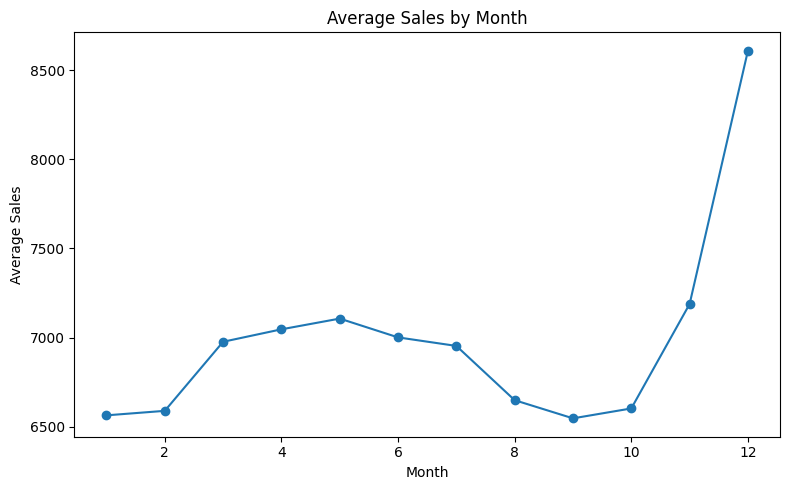

In [26]:
# 6. Monthly seasonality
plt.figure(figsize=(8, 5))
monthly_sales = train_data.groupby(train_data.index.month)['Sales'].mean()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

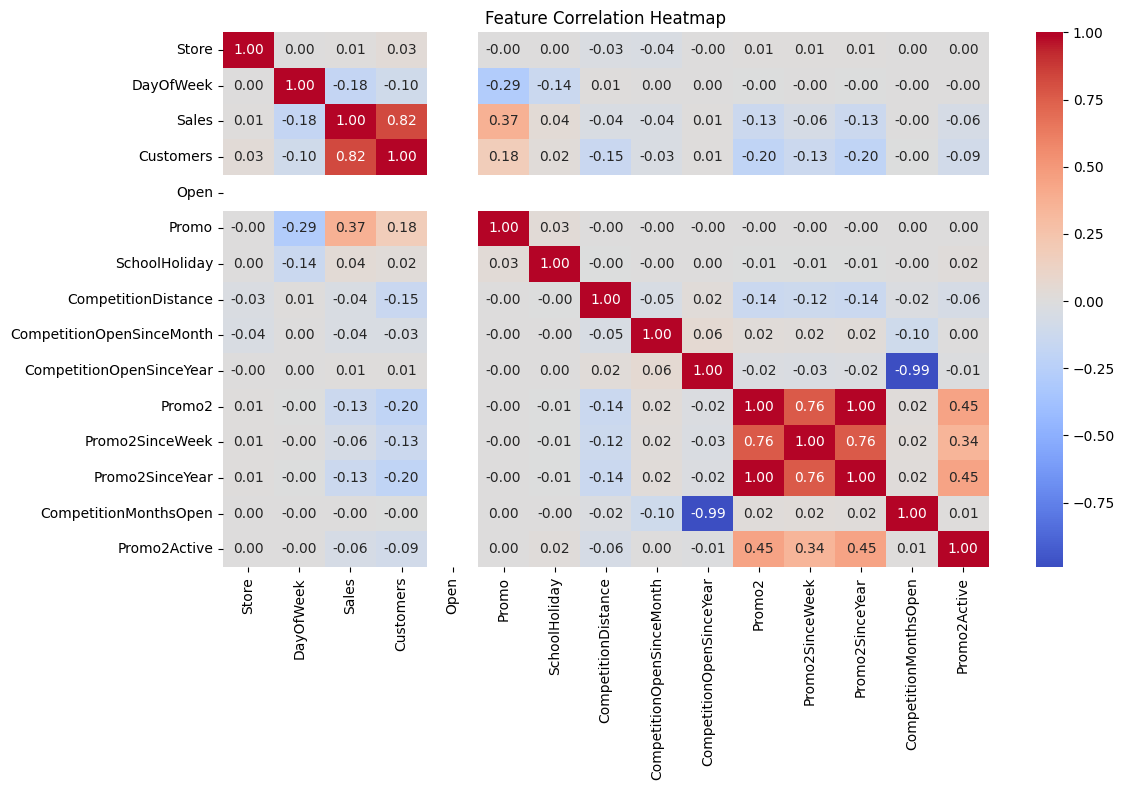

In [27]:
# Correlation analysis
numeric_cols = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

------------
##  Models

In [54]:
# RMSPE function
def rmspe(y_true, y_pred):
    mask = y_true != 0
    if np.sum(mask) == 0:
        return 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

In [29]:
# Filter store data
store_id = 1
store_data = train_data[train_data["Store"] == store_id].copy()
store_data = store_data.asfreq('D')
store_data["Sales"] = store_data["Sales"].fillna(0)

In [30]:
# Split data
train_ts = store_data.iloc[:-42]
valid_ts = store_data.iloc[-42:]

--------
### 02. Apply simple Forecasting models

In [48]:
# 1. Simple Mean Model
mean_sales_per_store = train_filtered.groupby('Store')['Sales'].mean()

def predict_mean(store_id, test_date):
    if store_id in mean_sales_per_store:
        return mean_sales_per_store[store_id]
    else:
        return train_filtered['Sales'].mean() # Fallback to overall mean

# Example prediction
example_store = 1
example_date = test.index[0]
mean_prediction = predict_mean(example_store, example_date)
print(f"Mean Sales Prediction for Store {example_store} on {example_date.date()}: {mean_prediction:.2f}")

Mean Sales Prediction for Store 1 on 2015-08-01: 4759.10


In [49]:
# 2. Last Day's Sales Model
def predict_last_day(store_id, test_date, train_data):
    store_train_data = train_data[train_data['Store'] == store_id].copy()
    # Find the last date in the training data before the test_date
    last_train_date = store_train_data.index[store_train_data.index < test_date].max()

    if pd.isna(last_train_date):
        # If no training data before test_date, use the mean
        return predict_mean(store_id, test_date)
    else:
        last_day_sales = store_train_data.loc[last_train_date, 'Sales']
        return last_day_sales

# Example prediction
example_store = 1
example_date = valid_ts.index[0] # Using the start of the validation period
last_day_prediction = predict_last_day(example_store, example_date, train_filtered)
print(f"Last Day's Sales Prediction for Store {example_store} on {example_date.date()}: {last_day_prediction:.2f}")

Last Day's Sales Prediction for Store 1 on 2015-06-20: 4202.00


In [51]:
# 3. 7-day Moving Average per Store
def predict_moving_average(store_id, test_date, train_data, window=7):
    store_train_data = train_data[train_data['Store'] == store_id].copy()
    # Filter training data up to the day before the test_date
    recent_data = store_train_data[store_train_data.index < test_date]

    if len(recent_data) < window:
        # Not enough data for moving average, use the mean
        return predict_mean(store_id, test_date)
    else:
        # Calculate the moving average up to the day before the test_date
        moving_avg = recent_data['Sales'].rolling(window=window).mean().iloc[-1]
        return moving_avg

# Example prediction
example_store = 1
example_date = valid_ts.index[7] # Using a date at least 7 days into the validation period
moving_avg_prediction = predict_moving_average(example_store, example_date, train_filtered)
print(f"7-day Moving Average Prediction for Store {example_store} on {example_date.date()}: {moving_avg_prediction:.2f}")

7-day Moving Average Prediction for Store 1 on 2015-06-27: 3729.00


In [56]:
def generate_predictions(model_func, valid_data, train_data=None, window=None):
    predictions = []
    for date, row in valid_data.iterrows():
        store_id = row['Store']

        if model_func.__name__ == 'predict_mean':
            pred = model_func(store_id, date)

        elif model_func.__name__ == 'predict_last_day':
            pred = model_func(store_id, date, train_data)

        elif model_func.__name__ == 'predict_moving_average':
            pred = model_func(store_id, date, train_data, window)

        else:
            raise ValueError(f"Unknown model function: {model_func.__name__}")

        predictions.append(pred)
    return np.array(predictions)

In [58]:
# True values
y_true = valid_ts["Sales"].values
# 1. Mean Model
mean_preds = generate_predictions(predict_mean, valid_ts)
# 2. Last Day Sales Model
last_day_preds = generate_predictions(predict_last_day, valid_ts, train_filtered)
# 3. 7-Day Moving Average Model
ma7_preds = generate_predictions(predict_moving_average, valid_ts, train_filtered, window=7)

In [59]:
# Evaluate
rmspe_mean = rmspe(y_true, mean_preds)
rmspe_last_day = rmspe(y_true, last_day_preds)
rmspe_ma7 = rmspe(y_true, ma7_preds)

# Print results
print("=== SIMPLE MODELS PERFORMANCE ===")
print(f"Mean Model RMSPE       : {rmspe_mean:.4f}")
print(f"Last Day Sales RMSPE   : {rmspe_last_day:.4f}")
print(f"7-Day MA Model RMSPE   : {rmspe_ma7:.4f}")

=== SIMPLE MODELS PERFORMANCE ===
Mean Model RMSPE       : 0.2133
Last Day Sales RMSPE   : 0.1253
7-Day MA Model RMSPE   : 0.1933


--------
### 03. Apply ETS model

In [60]:
results = {}

In [61]:
try:
    ets_model = ExponentialSmoothing(
        train_ts['Sales'],
        trend='add',
        seasonal='add',
        seasonal_periods=7
    )
    ets_fit = ets_model.fit(optimized=True)
    ets_forecast = ets_fit.forecast(42)
    ets_score = rmspe(valid_ts['Sales'], ets_forecast)
    results['ETS'] = ets_score
    print(f"ETS RMSPE: {ets_score:.4f}")
except Exception as e:
    print(f"ETS model failed: {e}")
    results['ETS'] = np.inf

ETS RMSPE: 0.1865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


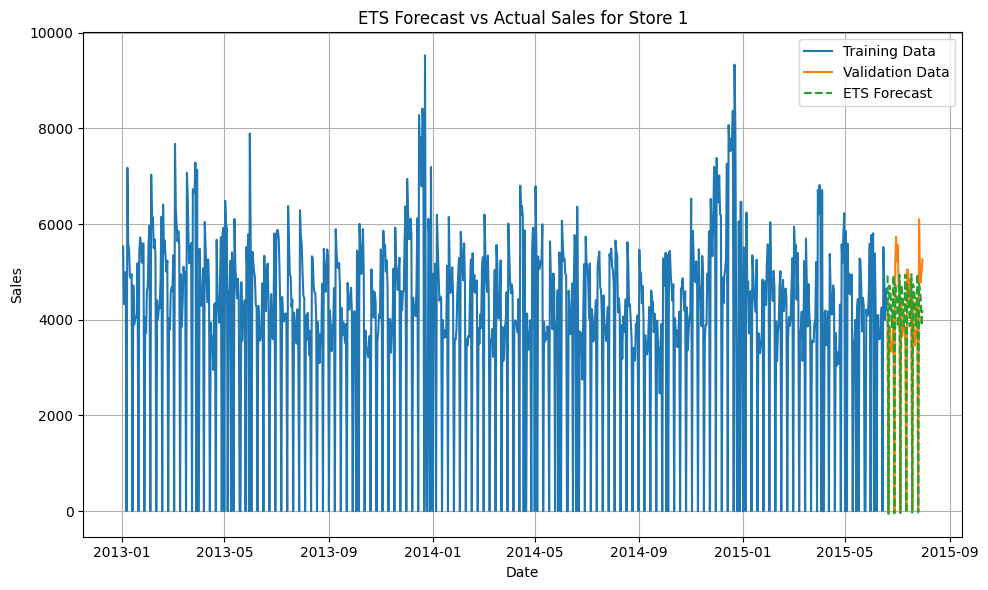

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts['Sales'], label='Training Data')
plt.plot(valid_ts.index, valid_ts['Sales'], label='Validation Data')
plt.plot(valid_ts.index, ets_forecast, label='ETS Forecast', linestyle='--')
plt.title(f'ETS Forecast vs Actual Sales for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--------
### 04. Apply the Arima model

In [62]:
try:
    arima_model = auto_arima(
        train_ts["Sales"],
        seasonal=True,
        m=7,  # weekly seasonality
        stepwise=True,
        suppress_warnings=True,
        max_p=3, max_q=3, max_P=2, max_Q=2
    )
    arima_forecast = arima_model.predict(n_periods=42)
    arima_score = rmspe(valid_ts['Sales'], arima_forecast)
    results['ARIMA'] = arima_score
    print(f"ARIMA RMSPE: {arima_score:.4f}")
except Exception as e:
    print(f"ARIMA model failed: {e}")
    results['ARIMA'] = np.inf

ARIMA RMSPE: 0.1698


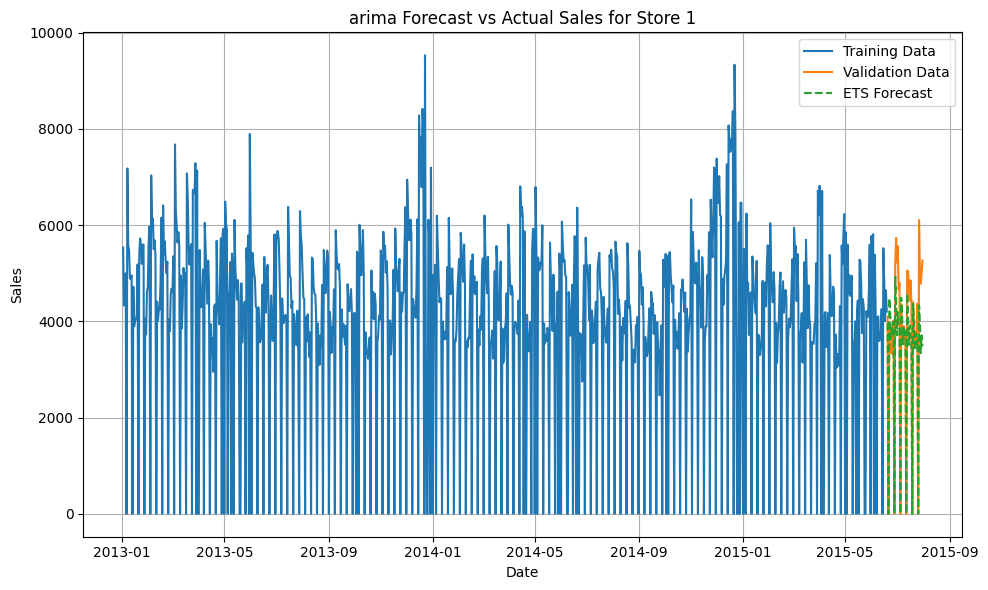

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts['Sales'], label='Training Data')
plt.plot(valid_ts.index, valid_ts['Sales'], label='Validation Data')
plt.plot(valid_ts.index, arima_forecast, label='ETS Forecast', linestyle='--')
plt.title(f'arima Forecast vs Actual Sales for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--------
### 05. Apply Prophet

In [64]:
try:
    prophet_data = train_ts.reset_index()[['Date', 'Sales']]
    prophet_data.columns = ['ds', 'y']
    prophet_data = prophet_data[prophet_data['y'] > 0]

    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True
    )
    prophet_model.fit(prophet_data)

    future = prophet_model.make_future_dataframe(periods=42)
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast['yhat'].iloc[-42:].values
    prophet_score = rmspe(valid_ts['Sales'], prophet_pred)
    results['Prophet'] = prophet_score
    print(f"Prophet RMSPE: {prophet_score:.4f}")
except Exception as e:
    print(f"Prophet model failed: {e}")
    results['Prophet'] = np.inf

DEBUG:cmdstanpy:input tempfile: /tmp/tmprjq5t392/7lgofvbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjq5t392/0f3q0rwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87318', 'data', 'file=/tmp/tmprjq5t392/7lgofvbq.json', 'init=/tmp/tmprjq5t392/0f3q0rwk.json', 'output', 'file=/tmp/tmprjq5t392/prophet_modelljvrhkze/prophet_model-20250531152644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSPE: 0.1720


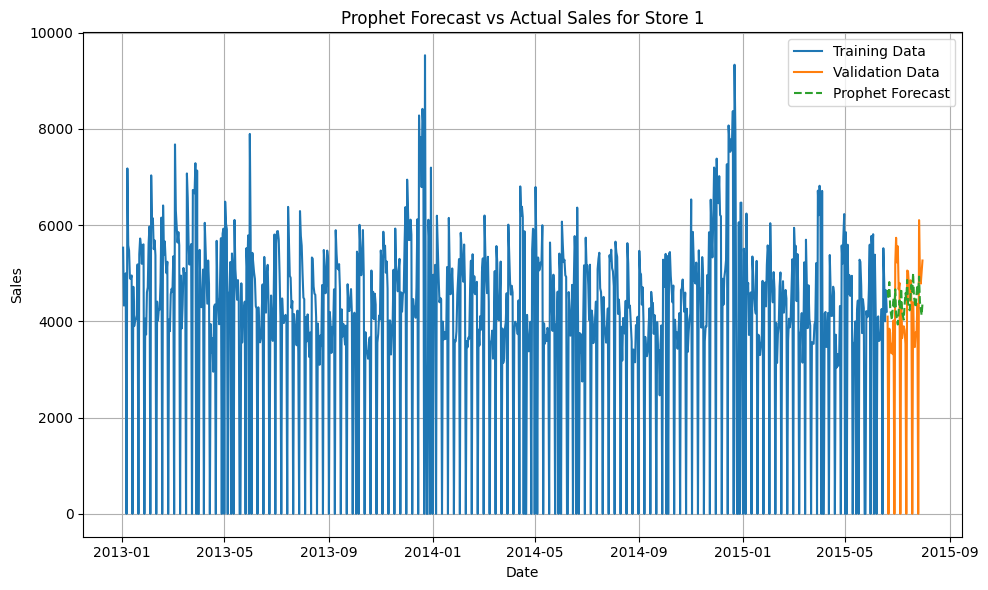

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts['Sales'], label='Training Data')
plt.plot(valid_ts.index, valid_ts['Sales'], label='Validation Data')
plt.plot(valid_ts.index, prophet_pred, label='Prophet Forecast', linestyle='--')
plt.title(f'Prophet Forecast vs Actual Sales for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--------
## 06. Apply any machine learning (XGBoost Model)

In [73]:
def create_lag_features(df, target_col, lags=[1, 7, 14, 30]):
    """Create lag features for time series"""
    print(f"Creating lag features for {target_col}...")
    df_copy = df.copy()
    for lag in lags:
        print(f"  Lag {lag}")
        df_copy[f'{target_col}_lag_{lag}'] = df_copy.groupby('Store')[target_col].shift(lag)
    return df_copy

In [74]:
def create_rolling_features(df, target_col, windows=[7, 14, 30]):
    """Create rolling statistics features"""
    print(f"Creating rolling features for {target_col}...")
    df_copy = df.copy()

    for window in windows:
        print(f"  Window {window}")
        # Create rolling features using groupby and transform to maintain index alignment
        df_copy[f'{target_col}_rolling_mean_{window}'] = df_copy.groupby('Store')[target_col].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df_copy[f'{target_col}_rolling_std_{window}'] = df_copy.groupby('Store')[target_col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df_copy[f'{target_col}_rolling_median_{window}'] = df_copy.groupby('Store')[target_col].transform(
            lambda x: x.rolling(window, min_periods=1).median()
        )

    return df_copy

In [75]:
def prepare_ml_features(data):
    """Comprehensive feature engineering for ML models"""

    print("Creating ML features...")
    data_ml = data.copy()

    # Time-based features
    data_ml = create_time_features(data_ml)

    # Lag features (avoid data leakage)
    # Only create lag features for 'Sales' if the column exists (i.e., for train data)
    if 'Sales' in data_ml.columns:
        data_ml = create_lag_features(data_ml, 'Sales', [7, 14, 30])
    if 'Customers' in data_ml.columns:
        data_ml = create_lag_features(data_ml, 'Customers', [1, 7])

    # Rolling features
    # Only create rolling features for 'Sales' if the column exists (i.e., for train data)
    if 'Sales' in data_ml.columns:
        data_ml = create_rolling_features(data_ml, 'Sales', [7, 14, 30])
    if 'Customers' in data_ml.columns:
        data_ml = create_rolling_features(data_ml, 'Customers', [7, 14])

    # Store-level statistics
    # Calculate store stats on original train data and join to both train_ml and test_ml
    # Avoid calculating sales-based stats on test_ml directly
    if 'Sales' in data.columns: # Use original 'data' to calculate stats before filtering/copying
        store_stats = data.groupby('Store')['Sales'].agg(['mean', 'std', 'median']).add_prefix('Store_Sales_')
        data_ml = data_ml.join(store_stats, on='Store')


    # Competition features
    data_ml['CompetitionDistanceLog'] = np.log1p(data_ml['CompetitionDistance'])
    data_ml['CompetitionOpen'] = (data_ml['CompetitionMonthsOpen'] > 0).astype(int)

    # Promo interaction features
    # Ensure StateHoliday is treated as string before checking for '0'
    data_ml['PromoStateHoliday'] = data_ml['Promo'] * (data_ml['StateHoliday'].astype(str) != '0').astype(int)
    data_ml['PromoSchoolHoliday'] = data_ml['Promo'] * data_ml['SchoolHoliday']

    # Encode categorical variables
    le = LabelEncoder()
    # Include StateHoliday, StoreType, Assortment, PromoInterval
    categorical_cols_to_encode = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
    for col in categorical_cols_to_encode:
        # Check if the column exists before encoding
        if col in data_ml.columns:
            # Handle potential NaN values or non-string types before encoding
            data_ml[f'{col}_encoded'] = le.fit_transform(data_ml[col].astype(str).fillna('None')) # Fill NaN with 'None' or similar

    return data_ml

In [76]:
def evaluate_ml_models(data, validation_days=42):
    """Evaluate machine learning models with time series cross-validation"""

    print("\n=== EVALUATING MACHINE LEARNING MODELS ===")

    # Prepare features
    data_ml = prepare_ml_features(data)

    # Define feature columns
    feature_cols = [
        'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'Customers',
        'Year', 'Month', 'Day', 'WeekOfYear', 'Quarter',
        'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
        'IsMonthStart', 'IsMonthEnd', 'IsWeekend',
        'CompetitionDistance', 'CompetitionMonthsOpen', 'CompetitionDistanceLog',
        'Promo2', 'Promo2Active', 'PromoStateHoliday', 'PromoSchoolHoliday',
        'StoreType_encoded', 'Assortment_encoded'
    ]

    # Add lag and rolling features if they exist
    lag_cols = [col for col in data_ml.columns if 'lag_' in col or 'rolling_' in col or 'Store_Sales_' in col]
    feature_cols.extend(lag_cols)

    # Filter available features
    available_features = [col for col in feature_cols if col in data_ml.columns]

    # Remove rows with NaN values (due to lag features)
    data_clean = data_ml[available_features + ['Sales']].dropna()

    # Time series split
    cutoff_date = data_clean.index.max() - pd.Timedelta(days=validation_days)
    train_ml = data_clean[data_clean.index <= cutoff_date]
    valid_ml = data_clean[data_clean.index > cutoff_date]

    X_train, y_train = train_ml[available_features], train_ml['Sales']
    X_valid, y_valid = valid_ml[available_features], valid_ml['Sales']

    results = {}

    # 1. XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_valid)
    xgb_score = rmspe(y_valid, xgb_pred)
    results['XGBoost'] = xgb_score
    print(f"XGBoost RMSPE: {xgb_score:.4f}")



    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    return results, xgb_model, available_features

In [77]:
ml_results, best_model, features = evaluate_ml_models(train_data)


=== EVALUATING MACHINE LEARNING MODELS ===
Creating ML features...
Creating lag features for Sales...
  Lag 7
  Lag 14
  Lag 30
Creating lag features for Customers...
  Lag 1
  Lag 7
Creating rolling features for Sales...
  Window 7
  Window 14
  Window 30
Creating rolling features for Customers...
  Window 7
  Window 14
Training XGBoost...
XGBoost RMSPE: 0.0555

Top 10 Most Important Features:
                        feature  importance
4                     Customers    0.339575
31         Sales_rolling_mean_7    0.141329
2                         Promo    0.103123
34        Sales_rolling_mean_14    0.102620
36      Sales_rolling_median_14    0.040056
24            StoreType_encoded    0.034134
42   Customers_rolling_median_7    0.030113
1                     DayOfWeek    0.024133
45  Customers_rolling_median_14    0.022613
32          Sales_rolling_std_7    0.021972


----------
## 07. Choose the best among them

In [78]:
def create_ensemble_model(data, test_data):
    """Create ensemble model and generate final predictions"""

    print("\n=== CREATING ENSEMBLE MODEL ===")

    # Prepare features for both train and test
    data_ml = prepare_ml_features(data)
    test_ml = prepare_ml_features(test_data)

    # Feature columns
    feature_cols = [
        'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday',
        'Year', 'Month', 'Day', 'WeekOfYear', 'Quarter',
        'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
        'IsMonthStart', 'IsMonthEnd', 'IsWeekend',
        'CompetitionDistance', 'CompetitionMonthsOpen',
        'Promo2', 'Promo2Active', 'PromoStateHoliday', 'PromoSchoolHoliday',
        'StoreType_encoded', 'Assortment_encoded'
    ]

    available_features = [col for col in feature_cols if col in data_ml.columns and col in test_ml.columns]

    # Train final model
    X_train = data_ml[available_features].fillna(0)
    y_train = data_ml['Sales']
    X_test = test_ml[available_features].fillna(0)

    # Primary model: XGBoost
    final_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        max_depth=8,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    final_model.fit(X_train, y_train)
    predictions = final_model.predict(X_test)

    # Ensure no negative predictions
    predictions = np.maximum(predictions, 0)

    return predictions, final_model

In [82]:
final_predictions, final_model = create_ensemble_model(train, test)


=== CREATING ENSEMBLE MODEL ===
Creating ML features...
Creating lag features for Sales...
  Lag 7
  Lag 14
  Lag 30
Creating lag features for Customers...
  Lag 1
  Lag 7
Creating rolling features for Sales...
  Window 7
  Window 14
  Window 30
Creating rolling features for Customers...
  Window 7
  Window 14
Creating ML features...


In [87]:
#  Summary of all results
print("\n=== SUMMARY OF RESULTS ===")
print(f"Simple Mean Model RMSPE    : {rmspe_mean:.4f}")
print(f"Last Day Sales RMSPE     : {rmspe_last_day:.4f}")
print(f"7-Day MA Model RMSPE     : {rmspe_ma7:.4f}")
print(f"ETS Model RMSPE          : {results.get('ETS', float('inf')):.4f}")
print(f"ARIMA Model RMSPE        : {results.get('ARIMA', float('inf')):.4f}")
print(f"Prophet Model RMSPE      : {results.get('Prophet', float('inf')):.4f}")
print(f"XGBoost Model RMSPE      : {ml_results.get('XGBoost', float('inf')):.4f}")

# Identify the best performing model
best_model_name = min(ml_results, key=ml_results.get)
print(f"\nBest Performing ML Model : {best_model_name} with RMSPE {ml_results[best_model_name]:.4f}")


=== SUMMARY OF RESULTS ===
Simple Mean Model RMSPE    : 0.2133
Last Day Sales RMSPE     : 0.1253
7-Day MA Model RMSPE     : 0.1933
ETS Model RMSPE          : 0.1865
ARIMA Model RMSPE        : 0.1698
Prophet Model RMSPE      : 0.1720
XGBoost Model RMSPE      : 0.0555

Best Performing ML Model : XGBoost with RMSPE 0.0555


### -> Prepare Kaggle Submission File

In [83]:
# Prepare submission
test_data_reset = test.reset_index()
submission = pd.DataFrame({
    'Id': test_data_reset['Id'],
    'Sales': final_predictions
})

In [84]:
submission.to_csv("enhanced_submission.csv", index=False)
print("Submission file saved as 'enhanced_submission.csv'")

Submission file saved as 'enhanced_submission.csv'


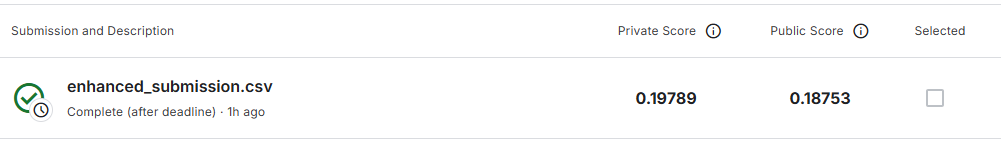

In [88]:
from IPython.display import Image, display
display(Image('/content/submission.PNG'))
